# Imports

In [2]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

# Load the data

In [3]:
imdb = tfds.load("imdb_reviews", as_supervised=True, data_dir="/kaggle/input/imdb-reviews-with-subword-vocab/up/data", download=False)

In [4]:
train_reviews = imdb['train'].map(lambda reviews, labels: reviews)
train_labels = imdb['train'].map(lambda reviews, labels: labels)

test_reviews = imdb['test'].map(lambda reviews, labels: reviews) 
test_labels = imdb['test'].map(lambda reviews, labels: labels)

# Prepare

In [5]:
# #compute the subword vocab and save to a file
# keras_nlp.tokenizers.compute_word_piece_vocabulary(
#     train_reviews,
#     vocabulary_size=8000,
#     reserved_tokens=["[PAD]", "[UNK]"],
#     vocabulary_output_file='imdb_vocab_subwords.txt'
# )

In [6]:
#initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='/kaggle/input/imdb-reviews-with-subword-vocab/up/imdb_vocab_subwords.txt'
)

In [7]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [8]:
def padding_func(sequences):
    sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

    sequences = sequences.get_single_element()

    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)
    
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

    return padded_sequences

In [9]:
# generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# combine the integer sequences and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword, train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword, test_labels)

# Optimize teh datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                        )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )

# Build the model

In [11]:
#model params
EMBEDDING_DIM = 64
FILTERS = 128
KERNEL_SIZE = 5
DENSE_DIM = 64

# build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Conv1D(filters=FILTERS, kernel_size=KERNEL_SIZE, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, None, 128)           │          41,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (None, 128)                 │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 538,049 (2.05 MB)

 Trainable params: 538,049 (2.05 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [14]:
NUM_EPOCHS = 10

history = model.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

Epoch 1/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 30s 241ms/step - accuracy: 0.5861 - loss: 0.6546 - val_accuracy: 0.8245 - val_loss: 0.3924
Epoch 2/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.8527 - loss: 0.3393 - val_accuracy: 0.8896 - val_loss: 0.2650
Epoch 3/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9250 - loss: 0.1984 - val_accuracy: 0.8868 - val_loss: 0.2736
Epoch 4/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9637 - loss: 0.1161 - val_accuracy: 0.8901 - val_loss: 0.2789
Epoch 5/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9806 - loss: 0.0689 - val_accuracy: 0.8888 - val_loss: 0.3103
Epoch 6/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9849 - loss: 0.0505 - val_accuracy: 0.8889 - val_loss: 0.3427
Epoch 7/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9862 - loss: 0.0402 - val_accuracy: 0.8818 - val_loss: 0.4027
Epoch 8/10
98/98 ━━━━━━━━━━━━━━━━━━━━ 18s 188ms/step - accuracy: 0.9963 - loss: 0.0183 - val_accu

# Plot history

In [24]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'o-', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'o-', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'o-', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'o-', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()

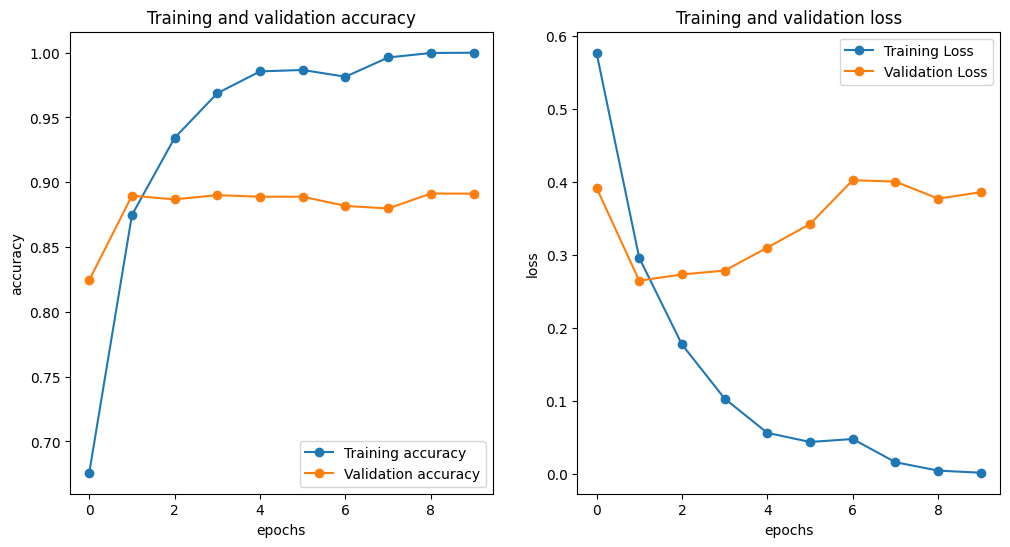

In [25]:
plot_loss_acc(history)